# Dependencies

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


## Some preprocessing

In [5]:
# Load flight data
df_fl = pd.read_csv("flights.csv",dtype={"ORIGIN_AIRPORT":str,"DESTINATION_AIRPORT":str})

In [6]:
# Problem: airline codes not coherent:
print(len(df_fl["ORIGIN_AIRPORT"].unique()))

628


In [7]:
# Solution: map it
# load airport codes
df_aircode1 = pd.read_csv('L_AIRPORT.csv')
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')

# Format the airport codes
df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))
aircode_dict["10423"]  = "AUS" # 10423 was encoded to BSM which is in IRAN istead of Austin-Bergstrom

# support function
def mymapper(label):
    """function to map 5-digit to 3-letter code"""
    if len(label) == 3:
        return label
    elif len(label) == 5:
        return aircode_dict[label]
    
# Fix the airport 5-digit > 3-letter code
df_fl['O_A'] = df_fl["ORIGIN_AIRPORT"].apply(mymapper)
df_fl["D_A"] = df_fl["DESTINATION_AIRPORT"].apply(mymapper)

In [8]:
# we finally find the 322 unique domestic airports
print((len(df_fl["D_A"].unique()),len(df_fl["O_A"].unique())))

(322, 322)


In [30]:
# Load up airports
airports = pd.read_csv('airports.csv')
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [11]:
airports.shape

(322, 7)

# Data exploration

In [58]:
df_fl.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'O_A', 'D_A', 'late_departure',
       'late_arrival'],
      dtype='object')

In [12]:
# Sneak peak
df_fl.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,O_A,D_A
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,SEA
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,PBI
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SFO,CLT
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,MIA
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SEA,ANC


In [32]:
# Amount of flights/airport
destsize = df_fl["D_A"].value_counts().sort_index()
orsize = df_fl["O_A"].value_counts().sort_index()

# Generate boolean variable to indicate delay
# x <= 0: False (i.e. no delay)
# x  > 0: True (i.e. delay)
df_fl["late_departure"] = [True if x > 0 else False for x in df_fl["DEPARTURE_DELAY"]]
df_fl["late_arrival"] = [True if x > 0 else False for x in df_fl["ARRIVAL_DELAY"]]

# Generate ratios of delayed flights for each airport
dept_delay_df = df_fl.pivot_table("late_departure",index="O_A")
arr_delay_df  = df_fl.pivot_table("late_arrival",index="D_A")
# put them together and sort on index (for plotting later on)
delaydf = pd.concat([dept_delay_df, arr_delay_df], axis=1).sort_index()

In [178]:
# Number of airports per state
airports.groupby('STATE').count().sort_values(by=['COUNTRY'],ascending=False).head()

,IATA_CODE,AIRPORT,CITY,COUNTRY,LATITUDE,LONGITUDE
STATE,,,,,,
TX,24,24,24,24,24,24
CA,22,22,22,22,22,22
AK,19,19,19,19,19,19
FL,17,17,17,17,15,15
MI,15,15,15,15,15,15


### Question: identify hubs (flight count & delays)

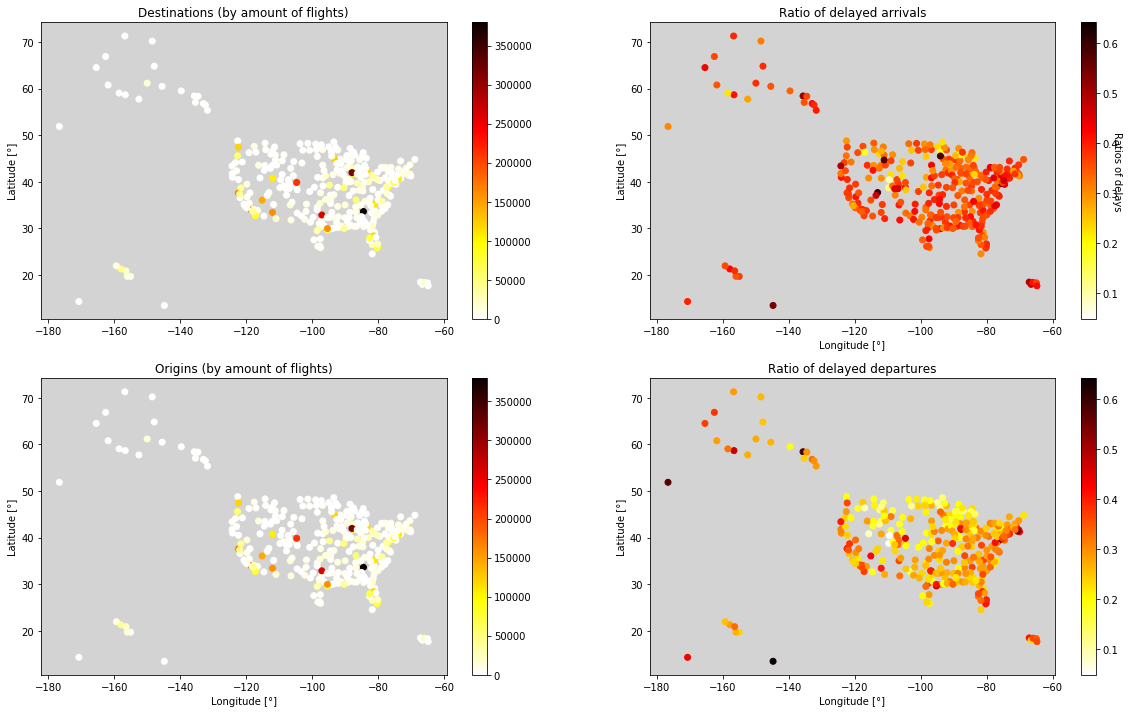

In [52]:
# Extract lat/long coordinates, sorted by IATA code
x = airports.sort_values(by="IATA_CODE")["LONGITUDE"].to_numpy()
y = airports.sort_values(by="IATA_CODE")["LATITUDE"].to_numpy()

# Make figure
plt.figure(figsize=(20,12))

# Showing airport importance based on number of flights
plt.subplot(2,2,1)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=destsize,cmap="hot_r")
plt.ylabel("Latitude [°]")
plt.title("Destinations (by amount of flights)");
plt.colorbar();
plt.clim(0,max(np.max(destsize),np.max(orsize)))

plt.subplot(2,2,3)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=orsize,cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Origins (by amount of flights)");
plt.colorbar();
plt.clim(0,max(np.max(deptsize),np.max(orsize)))

# Showing ratio of delays for airports
plt.subplot(2,2,4)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_departure"].to_numpy(),cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ratio of delayed departures");
cbar = plt.colorbar();
#cbar.set_label('Ratios of delayed departures', rotation=270)
plt.clim(np.minimum(dept_delay_df.min(),arr_delay_df.min()),
         np.maximum(dept_delay_df.max(),arr_delay_df.max()))

plt.subplot(2,2,2)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_arrival"].to_numpy(),cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ratio of delayed arrivals");
cbar = plt.colorbar();
cbar.set_label('Ratios of delays', rotation=270)
plt.clim(np.minimum(dept_delay_df.min(),arr_delay_df.min()),
         np.maximum(dept_delay_df.max(),arr_delay_df.max()))

### Question: is there a correlation between late departure and late arrival?

In [55]:
from scipy.stats.stats import pearsonr
pearsonr(dept_delay_df,arr_delay_df)
# => positive corelation ratio, but not purely linear

(array([0.50558084]), array([2.68714463e-22]))

### Question: what does the delay distribution look like?

In [65]:
# get delay times
a = df_fl["ARRIVAL_DELAY"].dropna().to_numpy()
d = df_fl["DEPARTURE_DELAY"].dropna().to_numpy()
# calculate kernel
kernel_a = stats.gaussian_kde(a)
kernel_d = stats.gaussian_kde(d)
# generate variables
dtime = np.arange(-50,100)
y_a = kernel_a(dtime)
y_d = kernel_d(dtime);

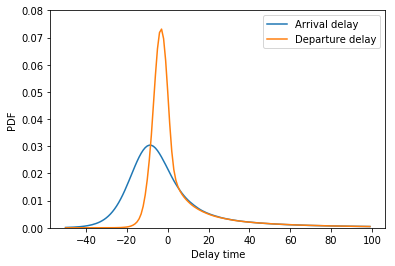

In [68]:
plt.plot(dtime,y_a,label="Arrival delay")
plt.plot(dtime,y_d,label="Departure delay")
plt.xlabel("Delay time")
plt.ylabel("PDF")
plt.legend();
plt.ylim(0,0.08);